In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import time

In [26]:
start = time.time()
df = pd.read_csv('co2_data.csv')
end = time.time()
print("Loading took " + str(round(end - start, 2)) + " seconds")

Loading took 0.0 seconds


In [27]:
df.head(5)

,CO2,Year&Month,Year
0,333.13,1974.38,1974
1,332.09,1974.46,1974
2,331.10,1974.54,1974
3,329.14,1974.63,1974
4,327.36,1974.71,1974


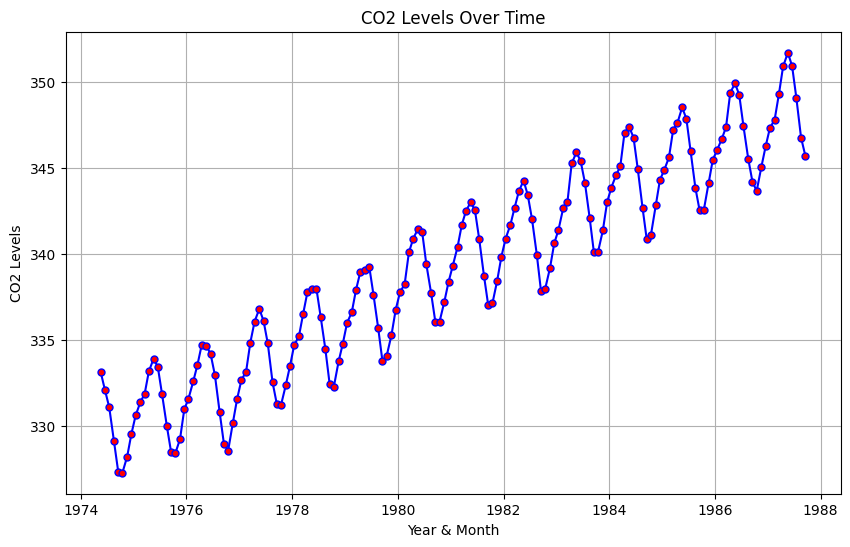

In [28]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df['Year&Month'], df['CO2'], marker='o',markersize=5,markerfacecolor='red', color='blue')
# Add labels and title
plt.xlabel('Year & Month')
plt.ylabel('CO2 Levels')
plt.title('CO2 Levels Over Time')
# Show the plot
plt.grid(True)
plt.show()

In [29]:
df.set_index('Year&Month', inplace=True)

In [30]:
df.drop('Year', axis=1, inplace=True)

In [31]:
train_start_dt = '1974.38'
test_start_dt = '1985.38'

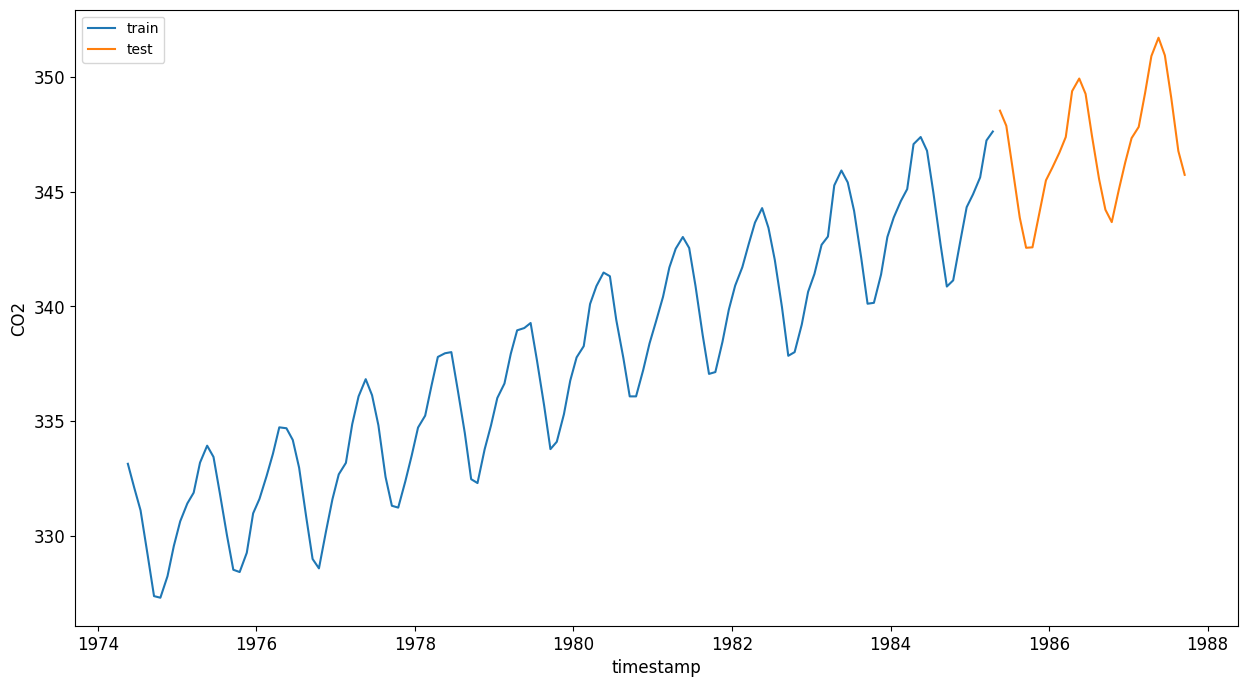

In [32]:
df[(df.index < float(test_start_dt)) & (df.index >= float(train_start_dt))][['CO2']].rename(columns={'CO2':'train'}) \
    .join(df[float(test_start_dt):][['CO2']].rename(columns={'CO2':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('CO2', fontsize=12)
plt.show()

In [35]:
train = df.copy()[(df.index >= float(train_start_dt)) & (df.index < float(test_start_dt))][['CO2']]
test = df.copy()[df.index >= float(test_start_dt)][['CO2']]

print('Training df shape: ', train.shape)
print('Test df shape: ', test.shape)

Training df shape:  (132, 1)
Test df shape:  (29, 1)


In [5]:
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

In [6]:
m = Prophet(weekly_seasonality=False)